##Load data

In [1]:
api_token = {"username":"lksdjflhsf","key":"35eea9d76784186ea9b2d8342bd58fca"}
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c kkbox-music-recommendation-challenge

100%|████████████████████████████████████████| 345M/345M [00:16<00:00, 24.1MB/s]
100%|████████████████████████████████████████| 345M/345M [00:16<00:00, 22.0MB/s]


In [3]:
!unzip -q kkbox-music-recommendation-challenge.zip

In [4]:
!7z e "/kaggle/working/members.csv.7z"
!7z e "/kaggle/working/songs.csv.7z"
!7z e "/kaggle/working/test.csv.7z"
!7z e "/kaggle/working/train.csv.7z"
!7z e "/kaggle/working/song_extra_info.csv.7z"
!7z e "/kaggle/working/sample_submission.csv.7z"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/workin                        1 file, 1349856 bytes (1319 KiB)

Extracting archive: /kaggle/working/members.csv.7z
--
Path = /kaggle/working/members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

    Everything is Ok

Size:       2503827
Compressed: 1349856

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C,Utf16=off,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/workin                        1 file, 105809525 bytes (101 MiB)

Extracting archive: /kaggle/working/songs.csv.7z
--
Path = /kaggle/working/songs.csv.7z
Type = 7z
Physical Size = 105809525
Headers Size = 122
M

##Imports

In [5]:
!pip -q install optuna
!pip -q install catboost

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns

import optuna
import shap
import catboost as cb
import lightgbm as lgbm
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, ndcg_score, log_loss, roc_curve, auc

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
train = reduce_mem_usage(pd.read_csv('train.csv'))
test = reduce_mem_usage(pd.read_csv('test.csv'))
sei = pd.read_csv('song_extra_info.csv')
members = pd.read_csv('members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('songs.csv')

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 82.41 MB
Decreased by 75.6%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 42.17 MB
Decreased by 64.0%


In [9]:
train = train.merge(songs,on='song_id',how='left')
train = train.merge(members,on = 'msno',how='left')
train_data = train.merge(sei,on = 'song_id',how='left')
test = test.merge(songs, on='song_id',how='left')
test = test.merge(members,on='msno',how = 'left')
test_data = test.merge(sei,on='song_id',how = 'left')
del songs, sei, members, train, test

In [10]:
train_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   msno                    7377418 non-null  object        
 1   song_id                 7377418 non-null  object        
 2   source_system_tab       7352569 non-null  category      
 3   source_screen_name      6962614 non-null  category      
 4   source_type             7355879 non-null  category      
 5   target                  7377418 non-null  int8          
 6   song_length             7377304 non-null  float64       
 7   genre_ids               7258963 non-null  object        
 8   artist_name             7377304 non-null  object        
 9   composer                5701712 non-null  object        
 10  lyricist                4198606 non-null  object        
 11  language                7377268 non-null  float64       
 12  city          

In [11]:
test_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      2556790 non-null  int32         
 1   msno                    2556790 non-null  object        
 2   song_id                 2556790 non-null  object        
 3   source_system_tab       2548348 non-null  category      
 4   source_screen_name      2393907 non-null  category      
 5   source_type             2549493 non-null  category      
 6   song_length             2556765 non-null  float64       
 7   genre_ids               2514680 non-null  object        
 8   artist_name             2556765 non-null  object        
 9   composer                1937486 non-null  object        
 10  lyricist                1332043 non-null  object        
 11  language                2556748 non-null  float64       
 12  city          

##Fill NA's

In [12]:
for col in ['source_screen_name',
    'source_system_tab', 'source_type', 'genre_ids',
    'artist_name', 'name', 'isrc', 'composer', 'lyricist', 'gender']:
    if train_data[col].dtype == 'category':
        train_data[col] = train_data[col].cat.add_categories(["no_info"]).fillna("no_info")
        test_data[col] = test_data[col].cat.add_categories(["no_info"]).fillna("no_info")
    else:
        train_data[col].fillna("nan", inplace=True)
        test_data[col].fillna("nan", inplace=True)

In [13]:
train_data['song_length'].fillna(train_data['song_length'].mean(), inplace=True)
train_data['song_length'] = train_data['song_length'].astype(np.uint8)

test_data['song_length'].fillna(test_data['song_length'].mean(), inplace=True)
test_data['song_length'] = test_data['song_length'].astype(np.uint8)

train_data['language'].fillna(train_data['language'].mode().values[0], inplace=True)
train_data['language'] = train_data['language'].astype(np.int8)

test_data['language'].fillna(test_data['language'].mode().values[0], inplace=True)
test_data['language'] = test_data['language'].astype(np.int8)

In [14]:
label_encode_cols = [
    'msno', 'song_id', 'source_screen_name',
    'source_system_tab', 'source_type', 'genre_ids',
    'artist_name', 'composer', 'lyricist', 'gender'
]

In [15]:
enc = LabelEncoder()
all_data = pd.concat([train_data, test_data])
for col in label_encode_cols:
    all_data[col] = enc.fit_transform(all_data[col])

In [16]:
n = len(train_data)
train_data = all_data[:n]
test_data = all_data[n:]

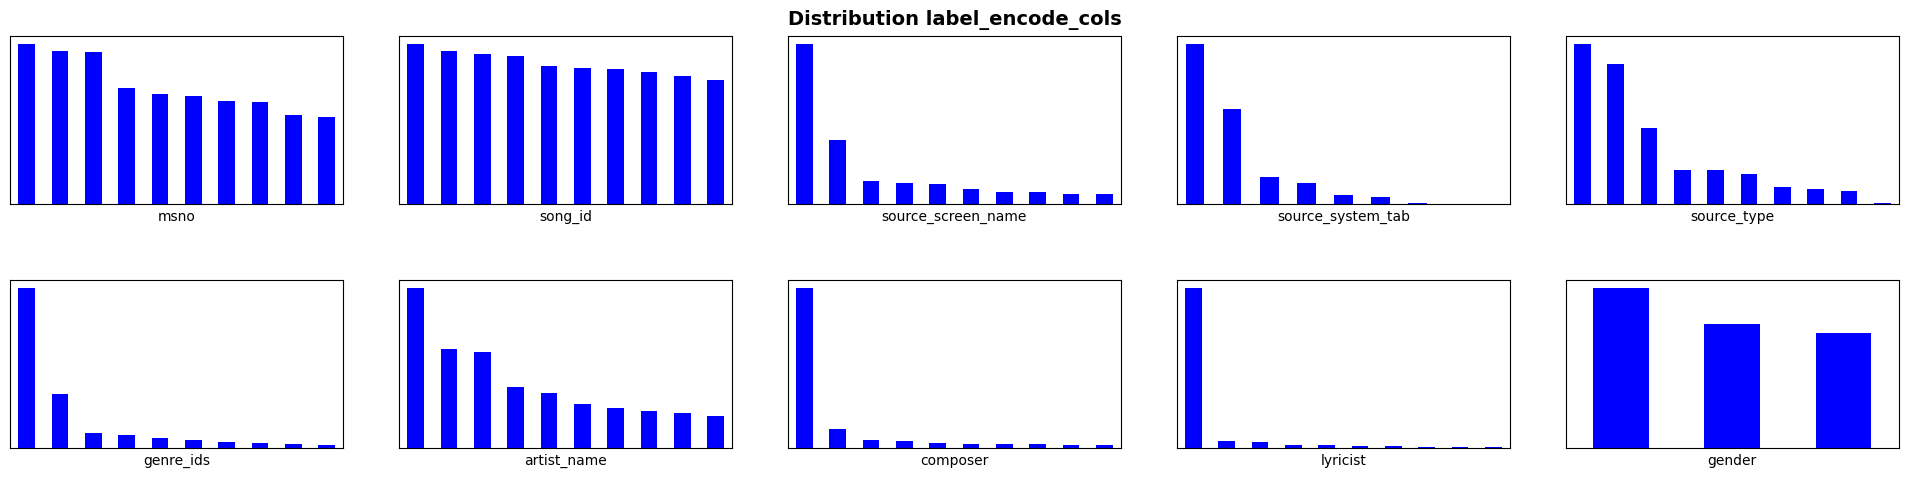

In [17]:
plt.figure(figsize=(20,15))
idx=0
for col in label_encode_cols:
    dist = train_data[col].value_counts(ascending=False).head(10)
    plt.subplot(6,5, idx+1)
    idx += 1
    dist.plot(kind='bar', color='blue')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=4.0)
plt.suptitle(f'Distribution label_encode_cols', size=14, weight='bold')
plt.show()

In [18]:
train_data.drop(columns=["id"], inplace=True)
ids = test_data['id'].values
test_data.drop(columns=["target", "id"], inplace=True)

In [19]:
train_data.drop(columns=["name", 'isrc'], inplace=True)
test_data.drop(columns=["name", 'isrc'], inplace=True)

##Feature generation

In [20]:
dict_count_song_played_train = {k: v for k, v in train_data['song_id'].items()}
dict_count_song_played_test = {k: v for k, v in test_data['song_id'].items()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train_data['number_of_time_played'] = train_data['song_id'].apply(lambda x: return_number_played(x))
test_data['number_of_time_played'] = test_data['song_id'].apply(lambda x: return_number_played(x))

In [21]:
dict_user_activity = {k:v for k,v in pd.concat([train_data['msno'] , test_data['msno']] , axis = 0).value_counts().items()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train_data['user_activity'] = train_data['msno'].apply(lambda x: return_user_activity(x))
test_data['user_activity'] = test_data['msno'].apply(lambda x: return_user_activity(x))

In [22]:
dict_composer_popularity = {k:v for k,v in pd.concat([train_data['composer'] , test_data['composer']] , axis = 0).value_counts().items()}
def return_composer_popularity(x):
    try:
        return dict_composer_popularity[x]
    except KeyError:
        return 0
train_data['composer_popularity'] = train_data['composer'].apply(lambda x: return_composer_popularity(x))
test_data['composer_popularity'] = test_data['composer'].apply(lambda x: return_composer_popularity(x))

In [23]:
train_data['membership_days'] = train_data['expiration_date'].subtract(train_data['registration_init_time']).dt.days.astype(int)
test_data['membership_days'] = test_data['expiration_date'].subtract(test_data['registration_init_time']).dt.days.astype(int)

In [24]:
cols = ["expiration_date", "registration_init_time"]
for col in cols:
    train_data[col+'_year'] = train_data[col].dt.year
    train_data[col+'_month'] = train_data[col].dt.month
    train_data[col+'_day'] = train_data[col].dt.day

    test_data[col+'_year'] = test_data[col].dt.year
    test_data[col+'_month'] = test_data[col].dt.month
    test_data[col+'_day'] = test_data[col].dt.day

In [25]:
train_data.drop(columns=cols, inplace=True)
test_data.drop(columns=cols, inplace=True)

In [26]:
min_max_scaling = ['number_of_time_played', 'user_activity', 'song_length', 'composer_popularity']

In [27]:
scaler = MinMaxScaler()
for col in min_max_scaling:
    train_data[col] = scaler.fit_transform(train_data[[col]])
    test_data[col] = scaler.transform(test_data[[col]])

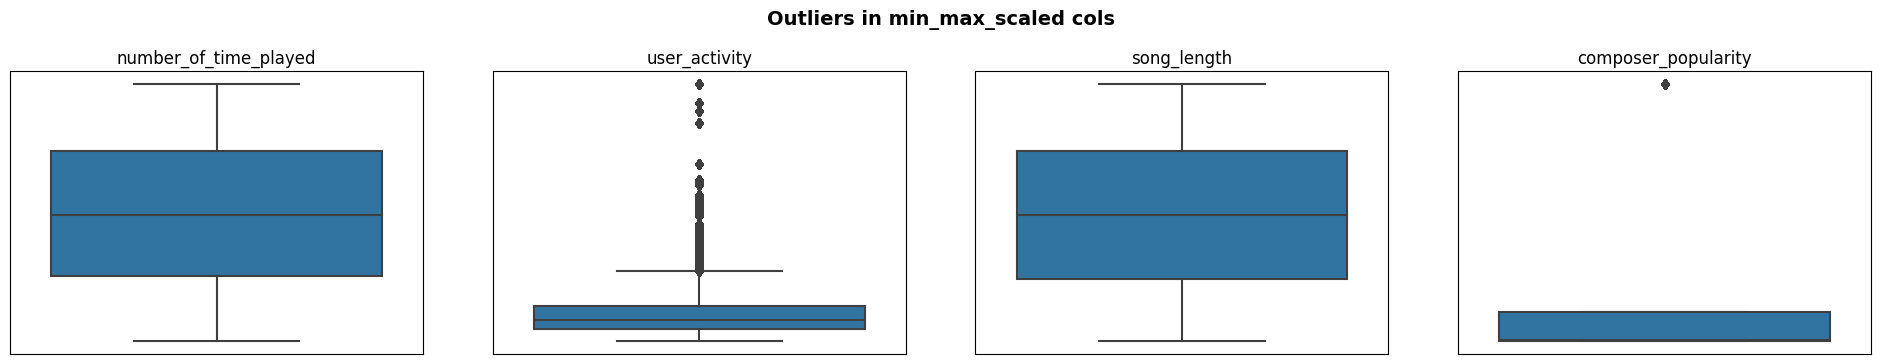

In [28]:
plt.figure(figsize=(20,15))
idx=0
for col in min_max_scaling:
    plt.subplot(4,4, idx+1)
    idx += 1
    sns.boxplot(data=train_data[col])
    plt.xticks([])
    plt.yticks([])
    plt.title(col)
plt.tight_layout(pad=5.0)
plt.suptitle(f'Outliers in min_max_scaled cols', size=14, weight='bold')
plt.show()

In [29]:
train_data.drop(columns=["membership_days"], inplace=True)
test_data.drop(columns=["membership_days"], inplace=True)

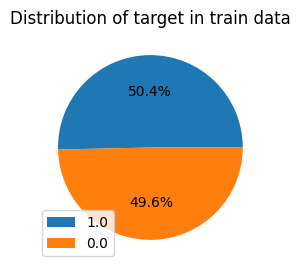

In [30]:
plt.figure(figsize=(3, 3))
train_data['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=None)
plt.title('Distribution of target in train data')
plt.ylabel('')
plt.legend(train_data['target'].value_counts().index)
plt.show()

<Axes: >

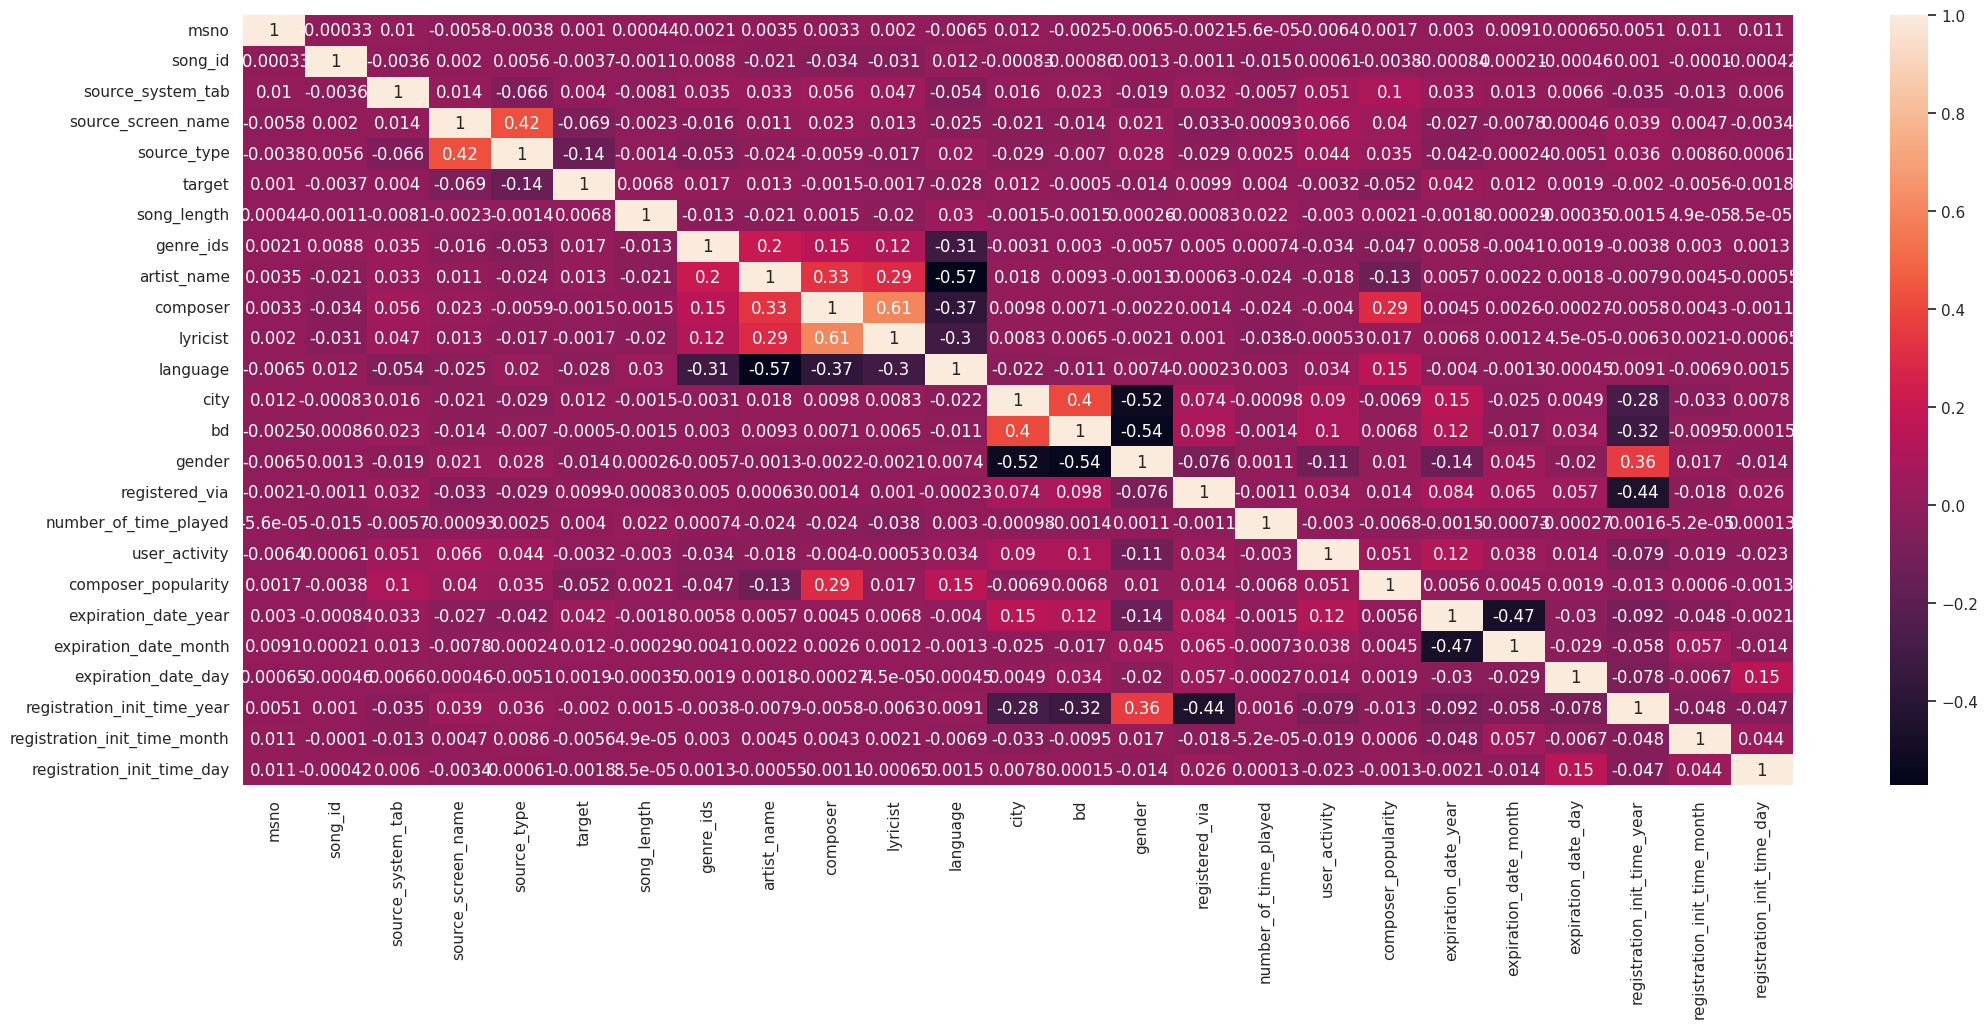

In [31]:
sns.set(rc={'figure.figsize':(25,10)})
corrmat = train_data.corr(method="pearson")
sns.heatmap(corrmat, annot=True)

In [32]:
X_train = train_data.drop(columns = ['target'] , axis = 1)
Y_train = train_data['target'].values
X_test = test_data

##Modeling

In [33]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
    if model_name == "LogReg":
        model = LogisticRegression()
    elif model_name == "Naive Bayes":
        model = GaussianNB()
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=100,
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=100,
            verbose=0
        )
    else :
        print("Model not found in function.")

    model.fit(X_train[:150000], y_train[:150000])

    y_pred = model.predict_proba(X_val[:150000])[:, 1]
    print()
    print("LogLoss :", log_loss(y_val[:150000], y_pred))
    print("ROC-AUC :", roc_auc_score(y_val[:150000], y_pred))

    print("==================================================")
    print()

In [34]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [35]:
models = ["LogReg", "Naive Bayes", "XGBoost Classifier", "CatBoost Classifier"]
for model in models:
    model_with(model, train_x, valid_x, train_y, valid_y)

Modeling with : LogReg


LogLoss : 0.6929441317725145
ROC-AUC : 0.5084839969101966

Modeling with : Naive Bayes


LogLoss : 0.6897423249359409
ROC-AUC : 0.5923848044885939

Modeling with : XGBoost Classifier


LogLoss : 0.6307311789792648
ROC-AUC : 0.6984460382918245

Modeling with : CatBoost Classifier


LogLoss : 0.6352686784581528
ROC-AUC : 0.691199989420613



In [36]:
def objective_cb(trial):
    params = {
        'iterations': 400,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 20.0),
        'random_strength': trial.suggest_float('random_strength', 1.0, 2.0),
        'depth': trial.suggest_int('depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        "use_best_model": True,
        "task_type": "GPU",
        'random_seed': 42
    }

    model = cb.CatBoostClassifier(**params)
    model.fit(train_x[:500000], train_y[:500000], eval_set=(valid_x[:500000], valid_y[:500000]), verbose=False)
    y_pred = model.predict_proba(valid_x[:500000])[:, 1]
    return roc_auc_score(valid_y[:500000], y_pred)

In [37]:
#study_cb = optuna.create_study(direction='maximize')
#optuna.logging.set_verbosity(optuna.logging.WARNING)
#study_cb.optimize(objective_cb, n_trials=60, show_progress_bar=True)

In [38]:
#print('Best parameters CatBoost', study_cb.best_params)

In [39]:
cb_params = {'learning_rate': 0.15102492983441101,
             'l2_leaf_reg': 4.742257732427735,
             'bagging_temperature': 0.2202504578829311,
             'random_strength': 1.0134801278520496,
             'depth': 10,
             'min_data_in_leaf': 228}

In [40]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 5000, 12000, step=100),
        "colsample_bytree" : trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
        "reg_lambda" : trial.suggest_float('reg_lambda', 1e-2, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 7, 8),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
        "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
    }

    model = xgb.XGBClassifier(
                                **params,
                                n_jobs=-1,
                                objective="binary:logistic",
                                tree_method='gpu_hist',
                                gpu_id=0
                              )
    model.fit(train_x[:300000], train_y[:300000])
    y_pred = model.predict_proba(valid_x[:300000])[:, 1]
    return roc_auc_score(valid_y[:300000], y_pred)

In [41]:
#study_xgb = optuna.create_study(direction='minimize')
#optuna.logging.set_verbosity(optuna.logging.WARNING)
#study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

In [42]:
#print('Best parameters XGB', study_xgb.best_params)

In [43]:
xgb_params = {'max_depth': 15,
          'learning_rate': 0.019648026825974014,
          'n_estimators': 6200,
          'colsample_bytree': 0.5162256610892388,
          'reg_lambda': 0.3475580072263198,
          'min_child_weight': 7,
          'reg_alpha': 0.6750067534465695,
          'gamma': 1.0,
          'subsample': 0.9623213899340335}

##Validation

In [44]:
n_folds = 5

def rocauc_cv(model):
    kf = StratifiedKFold(n_folds, shuffle=True, random_state=0).get_n_splits(train_x[:200000].values)
    rocauc = cross_val_score(model, train_x[:200000].values, train_y[:200000], scoring="roc_auc", verbose=0, cv = kf)
    return rocauc

In [45]:
def draw_roc_curve(predict, valid_y, name):
    fpr, tpr, thresholds = roc_curve(valid_y, predict)

    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC curve for {name} (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], 'r--')


    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

    plt.legend()

    plt.show()

In [46]:
model_xgb = xgb.XGBClassifier(
                            **xgb_params,
                            n_jobs=-1,
                            objective="binary:logistic",
                            tree_method='gpu_hist',
                            gpu_id=0
                            )
model_xgb.fit(X_train, Y_train)
None

In [47]:
model_cb = cb.CatBoostClassifier(**cb_params, iterations=2000, loss_function='Logloss', task_type="GPU", logging_level='Silent')
model_cb.fit(X_train, Y_train, verbose=False)
None

In [48]:
explainer = shap.Explainer(model_cb)
shap_values = explainer(valid_x)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()

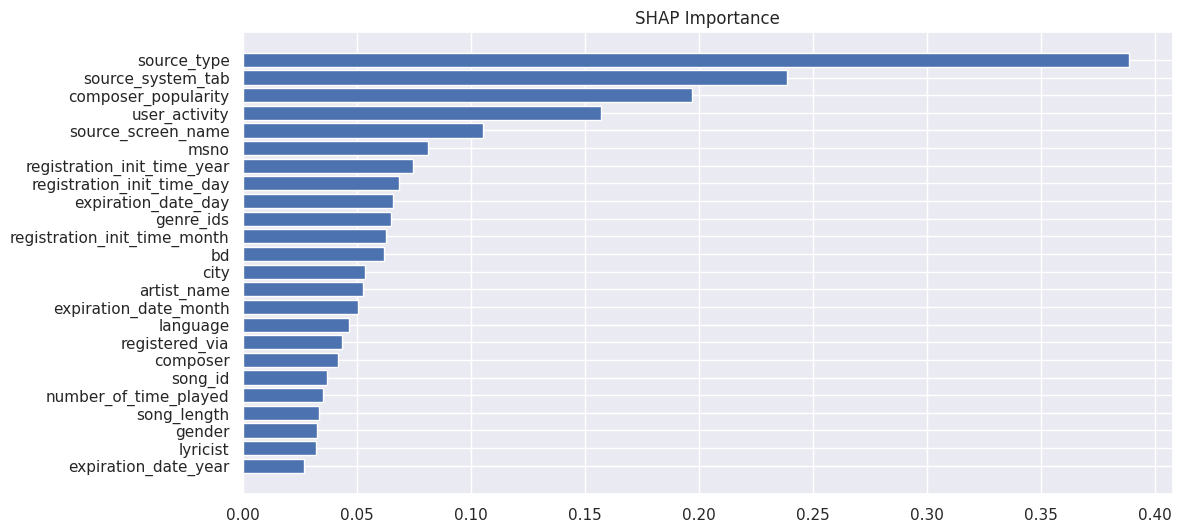

In [49]:
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(valid_x.columns)[sorted_idx])
plt.title('SHAP Importance')
plt.show()

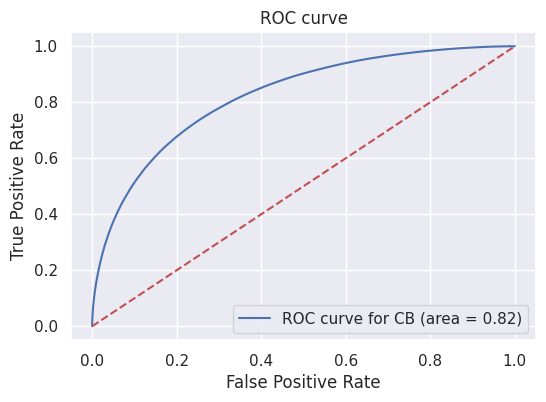

In [50]:
predict_cb = model_cb.predict_proba(valid_x)[:, 1]

draw_roc_curve(predict_cb, valid_y, "CB")

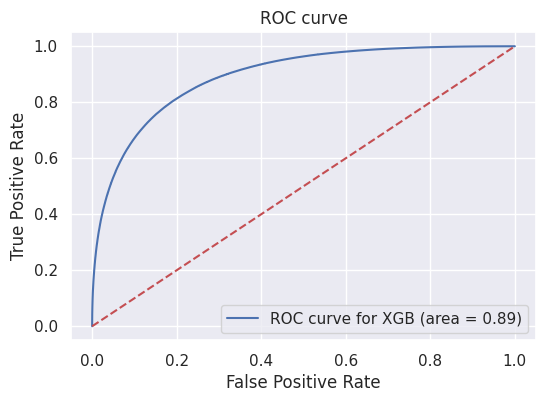

In [51]:
predict_xgb = model_xgb.predict_proba(valid_x)[:, 1]

draw_roc_curve(predict_xgb, valid_y, "XGB")

In [52]:
score_cb = rocauc_cv(model_cb)
print("\nCatBoost ROC-AUC: {:.4f}\n".format(score_cb.mean()))


CatBoost ROC-AUC: 0.6926



In [53]:
score_xgb = rocauc_cv(model_xgb)
print("\nXGBoost ROC-AUC: {:.4f}\n".format(score_xgb.mean()))


XGBoost ROC-AUC: 0.7210



##Count NDCG@20

In [54]:
def count_ndcg20(predict, valid_y):
    valid_df = valid_x[["msno", "song_id"]]
    valid_df['target'] = valid_y
    valid_df['predicted_value'] = predict
    grouped_data = valid_df.groupby('msno')
    ndcgs = []
    for user, group_data in grouped_data:
        group_data = group_data.sort_values(by='predicted_value', ascending=False)
        group_data['relevance'] = group_data['target'] * group_data['predicted_value']
        if len(group_data['relevance']) == 1:
            continue
        ndcg = ndcg_score([group_data['relevance']], [group_data['predicted_value']], k=20)
        ndcgs += [ndcg]
    return sum(ndcgs) / len(ndcgs)

In [55]:
print(f"\nNDCG@20 for XGB: {count_ndcg20(predict_xgb, valid_y)}")
print(f"\nNDCG@20 for CB: {count_ndcg20(predict_cb, valid_y)}")


NDCG@20 for XGB: 0.8317451996705078

NDCG@20 for CB: 0.7540514163515917


##Submission

In [ ]:
pred_test = model_xgb.predict_proba(X_test)[:, 1]

In [ ]:
sub = pd.DataFrame()
sub['id'] = ids.astype(int)
sub['target'] = pred_test
sub.head()

,id,target
0,0,0.400249
1,1,0.488870
2,2,0.112349
3,3,0.132941
4,4,0.137349


In [ ]:
sub.to_csv('sub.csv' , index = False)

In [ ]:
!kaggle competitions submit kkbox-music-recommendation-challenge -f sub.csv -m 'xgb'

100%|██████████████████████████████████████| 44.3M/44.3M [00:02<00:00, 19.1MB/s]
Successfully submitted to WSDM - KKBox's Music Recommendation Challenge

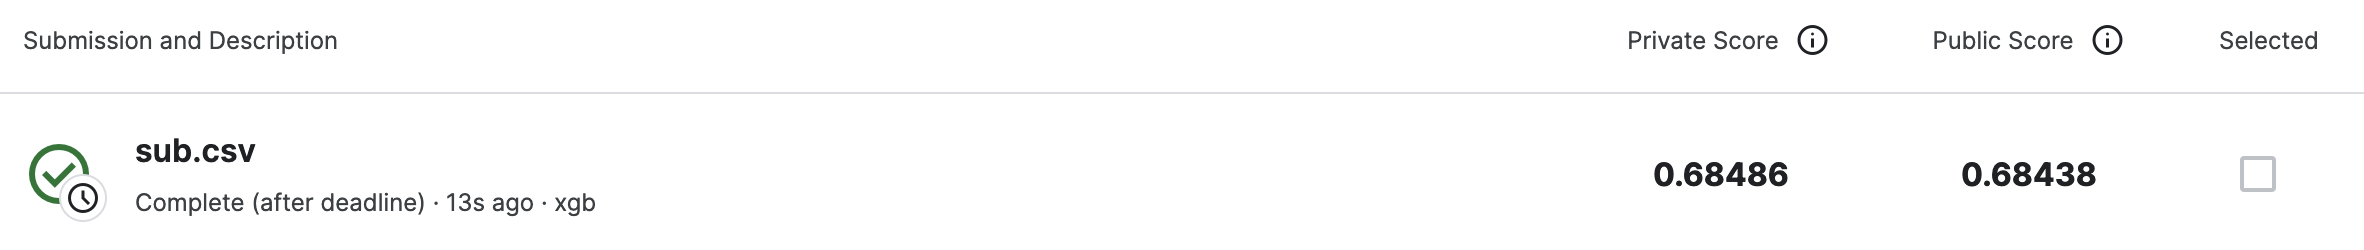